In [8]:
import os.path as osp

import torch
import torch.nn.functional as F

import torch_geometric as tg
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GraphConv, TopKPooling
from torch_geometric.nn import global_max_pool as gmp
from torch_geometric.nn import global_mean_pool as gap
import sys
from sklearn.metrics import f1_score, accuracy_score
import numpy as np

sys.path.append("../")
import utils
import warnings

warnings.filterwarnings("ignore")

In [9]:
train_dataset = utils.GraphDataset("../data/", "GunPoint", True, n_quantiles=40)
train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)

test_dataset = utils.GraphDataset("../data/", "GunPoint", False, n_quantiles=40)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))
for elem in train_dataset:
    break
elem

(50, 150)
(150, 150)


Data(edge_index=[2, 121], weight=[121], x=[40, 13], y=1, edge_attr=[121, 1])

In [10]:
class Net(torch.nn.Module):
    def __init__(self, in_features, hidden_channels=12, ratio=0.8):
        super().__init__()
        nn = tg.nn.MLP([in_features, hidden_channels])
        self.conv1 = tg.nn.GINEConv(nn, edge_dim=1)
        self.pool1 = TopKPooling(hidden_channels, ratio=ratio)
        nn = tg.nn.MLP([hidden_channels, hidden_channels])
        self.conv2 = tg.nn.GINEConv(nn, edge_dim=1)
        self.pool2 = TopKPooling(hidden_channels, ratio=ratio)
        nn = tg.nn.MLP([hidden_channels, hidden_channels])
        self.conv3 = tg.nn.GINEConv(nn, edge_dim=1)
        self.pool3 = TopKPooling(hidden_channels, ratio=ratio)

        self.lin1 = torch.nn.Linear(2 * hidden_channels, 16)
        self.lin2 = torch.nn.Linear(16, 8)
        self.lin3 = torch.nn.Linear(8, 2)

    def forward(self, data):
        x, edge_index, batch, edge_attr = (
            data.x,
            data.edge_index,
            data.batch,
            data.edge_attr,
        )

        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x, edge_index, edge_attr, batch, _, _ = self.pool1(
            x, edge_index, edge_attr, batch
        )
        x1 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(self.conv2(x, edge_index, edge_attr))
        x, edge_index, edge_attr, batch, _, _ = self.pool2(
            x, edge_index, edge_attr, batch
        )
        x2 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(self.conv3(x, edge_index, edge_attr))
        x, edge_index, edge_attr, batch, _, _ = self.pool3(
            x, edge_index, edge_attr, batch
        )
        x3 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = x1 + x2 + x3

        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.3, training=self.training)
        x = F.relu(self.lin2(x))
        x = F.log_softmax(self.lin3(x), dim=-1)

        return x

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net(13, hidden_channels=16).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, patience=5, mode="min", cooldown=2, factor=0.5, verbose=True
# )

In [12]:
def train():
    model.train()

    total_loss = 0
    for data in train_loader:
        optimizer.zero_grad()
        y_out = model(data)
        loss = F.nll_loss(y_out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
    return total_loss / len(train_loader.dataset)


@torch.no_grad()
def test(loader):
    model.eval()
    y_pred = []
    y_true = []
    loss = 0
    for data in loader:
        y_out = model(data)
        y_pred.append(y_out.argmax(dim=-1))
        y_true.append(data.y)
        loss += float(F.nll_loss(y_out, data.y) * data.num_graphs)
    y_pred = np.concatenate(y_pred)
    y_true = np.concatenate(y_true)
    return (
        f1_score(y_true=y_true, y_pred=y_pred, average="macro"),
        accuracy_score(y_true=y_true, y_pred=y_pred),
        loss / len(loader.dataset),
    )

In [13]:
best_macro_f1 = -1
train_losses = []
val_losses = []
for epoch in range(250):
    train()
    train_macro_f1, train_acc, train_loss = test(train_loader)
    test_macro_f1, test_acc, test_loss = test(test_loader)
    # scheduler.step(train_loss)
    print(
        f"Epoch: {epoch:03d}, Train_Loss: {train_loss:02.4f},Test_Loss: {test_loss:02.4f},Train_f1: {train_macro_f1:01.4f},Test_f1: {test_macro_f1:01.4f},Train_acc: {train_acc:01.4f},Test_acc: {test_acc:01.4f}"
    )
    if test_macro_f1 > best_macro_f1:
        best_accuracy = test_macro_f1
        best_epoch = epoch
        torch.save(model.state_dict(), "../data/best_model.pth")
    train_losses.append(train_loss)
    val_losses.append(test_loss)

Epoch: 000, Train_Loss: 0.9899,Test_Loss: 1.0479,Train_f1: 0.4945,Test_f1: 0.5290,Train_acc: 0.5600,Test_acc: 0.5733
Epoch: 001, Train_Loss: 0.9752,Test_Loss: 1.0399,Train_f1: 0.5251,Test_f1: 0.5332,Train_acc: 0.5800,Test_acc: 0.5733
Epoch: 002, Train_Loss: 0.9581,Test_Loss: 1.0360,Train_f1: 0.5544,Test_f1: 0.5550,Train_acc: 0.6000,Test_acc: 0.5867
Epoch: 003, Train_Loss: 0.9260,Test_Loss: 1.0261,Train_f1: 0.5544,Test_f1: 0.5605,Train_acc: 0.6000,Test_acc: 0.5933
Epoch: 004, Train_Loss: 0.9212,Test_Loss: 1.0141,Train_f1: 0.5544,Test_f1: 0.5694,Train_acc: 0.6000,Test_acc: 0.6000
Epoch: 005, Train_Loss: 0.8982,Test_Loss: 0.9963,Train_f1: 0.5385,Test_f1: 0.5694,Train_acc: 0.5800,Test_acc: 0.6000
Epoch: 006, Train_Loss: 0.9205,Test_Loss: 1.0091,Train_f1: 0.5544,Test_f1: 0.5660,Train_acc: 0.6000,Test_acc: 0.6000
Epoch: 007, Train_Loss: 0.9540,Test_Loss: 1.0193,Train_f1: 0.5251,Test_f1: 0.5623,Train_acc: 0.5800,Test_acc: 0.6000
Epoch: 008, Train_Loss: 0.9396,Test_Loss: 0.9935,Train_f1: 0.525

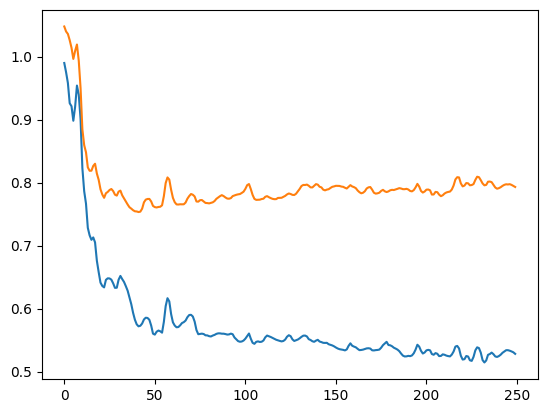

In [14]:
import matplotlib.pyplot as plt

plt.plot(train_losses)
plt.plot(val_losses)
plt.show()